What they do is replace every pixel that needs to be removed with a weighted average of it's neighbours. Since some of it's 
neighbours might also need to be removed, we get system of linear equations that we have to solve, to find the new values of the pixels we want to replace.

​

A custom single metric that is a combination of Least Relevant First and Most Relevant First:

(Least Relevant First - Most Relevant First) / 2, accross different thresholds.

In [15]:
import torch
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import io
import requests
import torchvision.transforms as transforms
from PIL import Image
from torchvision.transforms import Compose, Normalize, ToTensor
import torchvision.transforms as T

In [17]:

from ScoreCAM import ScoreCAM
from AblationCAM import AblationCAM
from model_tragets import ClassifierOutputTarget,ClassifierOutputSoftmaxTarget
from functions import show_cam_on_image
import functions as func
import helper as help

In [44]:


def random_initialization(A, rank):
    number_of_documents = A.shape[0]
    number_of_terms = A.shape[1]
    W = np.random.uniform(1, 2, (number_of_documents, rank))
    H = np.random.uniform(1, 2, (rank, number_of_terms))
    return W, H


def nndsvd_initialization(A, rank):
    u, s, v = np.linalg.svd(A, full_matrices=False)
    v = v.T
    w = np.zeros((A.shape[0], rank))
    h = np.zeros((rank, A.shape[1]))

    w[:, 0] = np.sqrt(s[0])*np.abs(u[:, 0])
    h[0, :] = np.sqrt(s[0])*np.abs(v[:, 0].T)

    for i in range(49):

        ui = u[:, i-1]
        vi = v[:, i-1]
        ui_pos = (ui >= 0)*ui
        ui_neg = (ui < 0)*-ui
        vi_pos = (vi >= 0)*vi
        vi_neg = (vi < 0)*-vi

        ui_pos_norm = np.linalg.norm(ui_pos, 2)
        ui_neg_norm = np.linalg.norm(ui_neg, 2)
        vi_pos_norm = np.linalg.norm(vi_pos, 2)
        vi_neg_norm = np.linalg.norm(vi_neg, 2)

        norm_pos = ui_pos_norm*vi_pos_norm
        norm_neg = ui_neg_norm*vi_neg_norm

        if norm_pos >= norm_neg:
            w[:, i] = np.sqrt(s[i-1]*norm_pos)/ui_pos_norm*ui_pos
            h[i, :] = np.sqrt(s[i-1]*norm_pos)/vi_pos_norm*vi_pos.T
        else:
            w[:, i] = np.sqrt(s[i-1]*norm_neg)/ui_neg_norm*ui_neg
            h[i, :] = np.sqrt(s[i-1]*norm_neg)/vi_neg_norm*vi_neg.T

    return w, h


def mu_method(A, k, max_iter, init_mode='nndsvd'):

    if init_mode == 'random':
        W, H = random_initialization(A, k)
    elif init_mode == 'nndsvd':
        W, H = nndsvd_initialization(A, k)
    norms = []
    e = 1.0e-10
    for n in range(max_iter):
        # Update H
        W_TA = W.T@A
        W_TWH = W.T@W@H+e
        for i in range(np.size(H, 0)):
            for j in range(np.size(H, 1)):
                H[i, j] = H[i, j] * W_TA[i, j] / W_TWH[i, j]
        # Update W
        AH_T = A@H.T
        WHH_T = W@H@H.T + e

        for i in range(np.size(W, 0)):
            for j in range(np.size(W, 1)):
                W[i, j] = W[i, j] * AH_T[i, j] / WHH_T[i, j]

        norm = np.linalg.norm(A - W@H, 'fro')
        norms.append(norm)
    return W, H, norms



def get_2d_projection(activation_batch):    
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
#     print(activation_batch.shape)
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        reshaped_activations = reshaped_activations - \
            reshaped_activations.mean(axis=0)
#         print(reshaped_activations.shape)
        W,H,norms = mu_method(reshaped_activations,2048,10)
#         print(reshaped_activations.shape)
#         print(H[0,:].shape)
        projection = reshaped_activations @ H[0, :]
#         print(projection.shape)
        projection = projection.reshape(activations.shape[1:])
#         print(projection.shape) #(16, 29)
        projections.append(projection)
#     print((np.float32(projections)).shape) #(2, 16, 29)
    return np.float32(projections)





def get_2d_projection_og(activation_batch):
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        # Centering before the SVD seems to be important here,
        # Otherwise the image returned is negative
        reshaped_activations = reshaped_activations - \
            reshaped_activations.mean(axis=0)
        U, S, VT = np.linalg.svd(reshaped_activations, full_matrices=True)
        projection = reshaped_activations @ VT[0, :]
        projection = projection.reshape(activations.shape[1:])
        projections.append(projection)
    return np.float32(projections)


In [45]:
from base import BaseCAM

class EigenCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(EigenCAM, self).__init__(model,
                                       target_layers,
                                       use_cuda,
                                       reshape_transform,
                                       uses_gradients=False)

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth):
        return get_2d_projection(activations)

In [46]:
# Showing the metrics on top of the CAM : 
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [ ("EigenCAM", EigenCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
#         global attributions
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                          targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]    
        visualization = show_cam_on_image(cg, attribution, use_rgb=True)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))


def preprocess_image(
    img: np.ndarray, mean=[
        0.5, 0.5, 0.5], std=[
            0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)


Resnet50 model and [model.layer4]

Butterfly


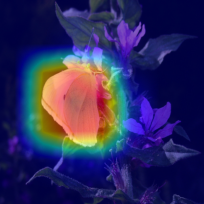

In [28]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000031.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)

Fig

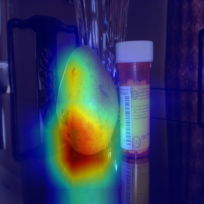

In [32]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000112.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=951)

Cat

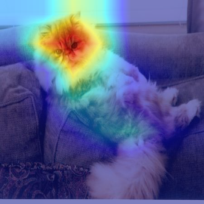

In [33]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000130.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=281)

Dog

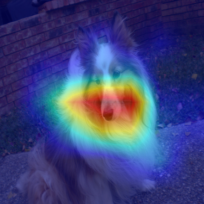

In [34]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000003.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)